# Introduction

This notebook attemnpts to identify simple heuristics to reduce the ratio of gains vs losses in the backtester. The current gain ratio is 1.5:1 (or 1.5/(1+1.5)=0.6). The gain ratio in the possible trades dataframe is 2:1 (or (2/(1+3)=0.67). Stop losses limit the consequences of losses, but any improvement in the gain ratio means we will be able to make more more as will be adding money to the total capital instead of loosing capital.

Note that in notebook `Analyze_possible_trades.ipynb` we develop a simple machine learning model (balanced scorecard) to improve the gain ratio. Although it does work, it does it in such a way that it also reduces the high gainers, and will overall result in less gain. As a result, it is not a practical model to implement.

This is the reason for trying some simple/general heuristic that will improve things.

In [1]:

from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Read The Data

Read in the 20k possible trades from CSV file.

In [3]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
possible_trades_df = pd.read_csv(f'{DATAPATH}possible_trades_2000.csv')
possible_trades_df

,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker
0,2018-08-10,7.20,2018-08-13,7.40,2.78,1,2.78,PIH
1,2018-08-20,7.10,2019-02-04,4.50,-36.62,114,-0.40,PIH
2,2019-04-03,5.23,2019-06-06,5.80,10.90,44,0.24,PIH
3,2019-06-28,4.95,2019-08-12,5.23,5.66,30,0.18,PIH
4,2019-09-09,4.97,2019-09-10,5.11,2.82,1,2.82,PIH
...,...,...,...,...,...,...,...,...
20911,2019-08-02,22.75,2019-10-11,31.19,37.10,49,0.65,ZUMZ
20912,2019-10-21,33.07,2019-11-05,32.63,-1.33,11,-0.12,ZUMZ
20913,2019-12-02,30.58,2019-12-20,31.86,4.19,14,0.29,ZUMZ
20914,2020-01-03,33.83,2020-01-10,33.78,-0.15,5,-0.03,ZUMZ


# Plot The Ful Data Set

The plot below shows the percentage gain versus the number of trading days. This is an important chart as it shows the percentge gain and the number of days of each trade. The longer a trade takes the more risk is involve. As a result we don't want long running trades that loose money.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


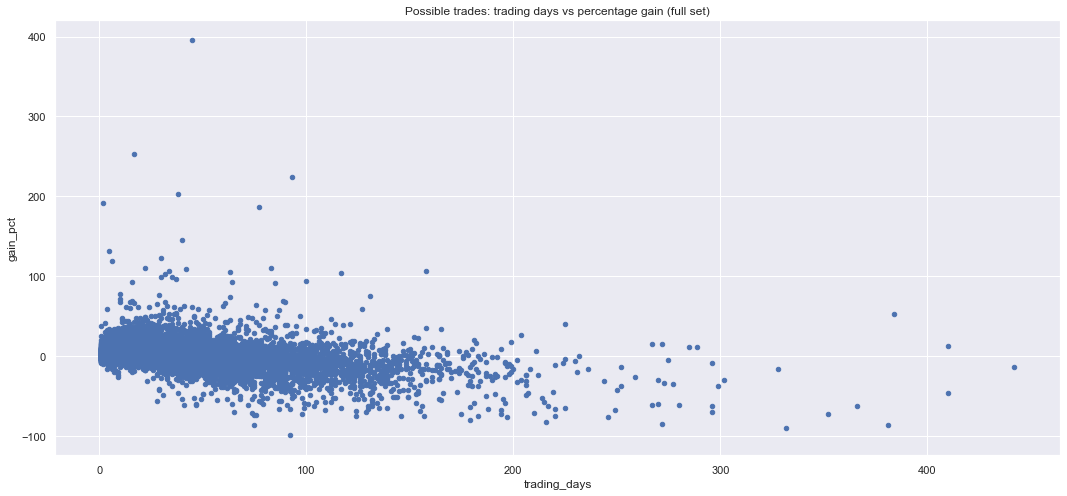

In [4]:
possible_trades_df.plot.scatter(x='trading_days', y='gain_pct', figsize=(18,8))
plt.title('Possible trades: trading days vs percentage gain (full set)')
plt.show()

# Plot Data for Test Set

The backtester simulates possible trades for test set only Tghis plot shows the data for the test set, so we get a sense of what is possible. You can see that some of the high return combinations are no longer present (e.g. the 400 percent gain).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


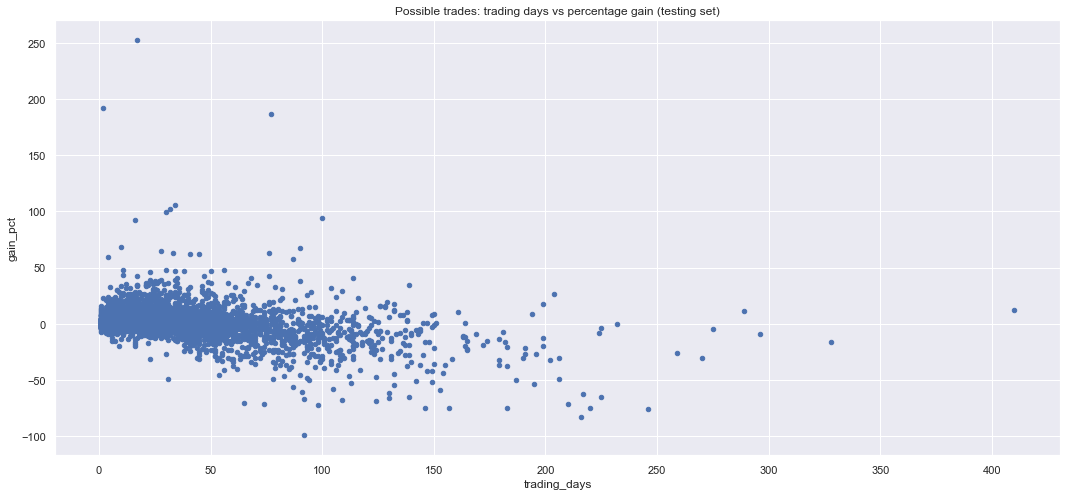

In [5]:
starting_at = int(len(possible_trades_df)*0.7)
possible_trades_df.iloc[starting_at:].plot.scatter(x='trading_days', y='gain_pct', figsize=(18,8))
plt.title('Possible trades: trading days vs percentage gain (testing set)')
plt.show()

# Display Trades That Make More Than Fifty Percent

To get a sense of the data. The below cell displays the trades that gain more than 50 percent. Note that this is for the full data set.

In [6]:
pd.set_option("display.max_rows", 101)
print(len(possible_trades_df.loc[possible_trades_df.gain_pct > 50].sort_values(by='gain_pct', ascending=False)))
possible_trades_df.loc[possible_trades_df.gain_pct > 50].sort_values(by='gain_pct', ascending=False)

68


,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker
3917,2018-04-24,1.1000,2018-06-27,5.4500,395.45,45,3.62,CTRC
18323,2019-11-14,2.2700,2019-12-10,8.0000,252.42,17,7.69,TCCO
14186,2017-04-10,7.3000,2017-08-22,23.6500,223.97,93,1.27,OPNT
13834,2019-04-24,0.8800,2019-06-18,2.6600,202.27,38,2.95,NOVN
18164,2019-10-09,1.8000,2019-10-11,5.2500,191.67,2,70.78,SES
16717,2019-10-30,1.4700,2020-02-21,4.2200,187.07,77,1.38,SELB
13382,2019-11-29,1.4400,2020-01-29,3.5300,145.14,40,2.27,NLS
425,2017-07-12,1.0100,2017-07-19,2.3400,131.68,5,18.30,AEZS
12500,2019-10-23,1.8700,2019-12-05,4.1600,122.46,30,2.70,MRSN
5305,2020-01-10,4.2900,2020-01-21,9.3800,118.65,6,13.93,CSS


# Calculate Statistics Per Ticker

The cells below calculate per ticker the mean gain, the standard deviation gain, the number of gain trades, and the mean percentage gain. Idem ditto for loss. And, lastly, the number of zero trades per ticker. The result is stored in a dataframe (i.e. `ticker_stats_df`).

In [7]:
possible_trades_df['gain']=possible_trades_df.sell_close - possible_trades_df.buy_close

In [8]:
tickers = list(possible_trades_df.ticker.unique())

In [9]:
cols = ['ticker', 
        'mean_gain', 'std_gain', 'cnt_gain', 'pct_gain',
        'mean_loss', 'std_loss', 'cnt_loss',  'pct_loss',
        'zero_cnt'
       ]
ticker_stats_df = pd.DataFrame(columns=cols)

for t in tickers:
    ticker_df = possible_trades_df.loc[possible_trades_df.ticker == t]

    mean_gain = float(ticker_df.gain.loc[ticker_df.gain > 0].mean())
    std_gain  = float(ticker_df.gain.loc[ticker_df.gain > 0].std())
    cnt_gain  = int(ticker_df.gain.loc[ticker_df.gain > 0].count())
    buy_sum   = float(ticker_df.buy_close.loc[ticker_df.gain > 0].sum())
    if buy_sum > 0: 
        pct_gain = (mean_gain * cnt_gain) / buy_sum
    else:
        pct_gain = float('NaN')

    mean_loss = float(ticker_df.gain.loc[ticker_df.gain < 0].mean())
    std_loss  = float(ticker_df.gain.loc[ticker_df.gain < 0].std())
    cnt_loss  = int(ticker_df.gain.loc[ticker_df.gain < 0].count())
    buy_sum   = float(ticker_df.buy_close.loc[ticker_df.gain > 0].sum())
    if buy_sum > 0: 
        pct_loss = (mean_loss * cnt_loss) / buy_sum
    else:
        pct_loss = float('NaN')

    zero_cnt  = int(ticker_df.gain.loc[ticker_df.gain == 0].count())

    # print(f'mean_gain={round(mean_gain,2)} std_gain={round(std_gain,3)} cnt_gain={cnt_gain} pct_gain={pct_gain}')
    # print(f'mean_loss={round(mean_loss,2)} std_gain={round(std_loss,3)} cnt_gain={cnt_loss} pct_loss={pct_loss}')
    # print(f'zero_cnt={zero_cnt}')
    # print('')

    t_dict = {'ticker': [t], 
              'mean_gain': [mean_gain], 'std_gain': [std_gain], 'cnt_gain': [cnt_gain], 'pct_gain': [pct_gain],
              'mean_loss': [mean_loss], 'std_loss': [std_loss], 'cnt_loss': [cnt_loss], 'pct_loss': [pct_loss],
              'zero_cnt' : [zero_cnt]
             }
    t_df   = pd.DataFrame(t_dict)
    ticker_stats_df = pd.concat([ticker_stats_df, t_df])

ticker_stats_df.cnt_gain = ticker_stats_df.cnt_gain.astype(int)
ticker_stats_df.cnt_loss = ticker_stats_df.cnt_loss.astype(int)
ticker_stats_df.zero_cnt = ticker_stats_df.zero_cnt.astype(int)

ticker_stats_df

,ticker,mean_gain,std_gain,cnt_gain,pct_gain,mean_loss,std_loss,cnt_loss,pct_loss,zero_cnt
0,PIH,0.200000,0.183394,7,0.038525,-1.375000,1.732412,2,-0.075674,0
0,FCCY,0.800000,0.852807,6,0.044395,-0.400000,0.322224,8,-0.029597,0
0,SRCE,2.112308,2.701719,13,0.044086,-2.180000,2.355589,3,-0.010500,0
0,MMM,7.825000,4.613965,6,0.040652,-24.050000,15.414928,2,-0.041648,0
0,ATEN,0.590000,0.288704,5,0.092101,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...
0,ZN,0.375000,0.723187,8,0.226244,-0.210000,0.226274,2,-0.031674,0
0,ZION,2.293636,1.497513,11,0.050777,-1.000000,NaN,1,-0.002013,0
0,ZIOP,0.517273,0.547304,11,0.121894,-0.555556,0.595086,9,-0.107112,0
0,ZIXI,0.795000,1.278886,6,0.139270,-0.293333,0.180370,3,-0.025693,0


# Calculate Gain Ratio

With the gain count and loss counts per ticker, we can no calculate the gain ratio per ticker.

In [10]:
ticker_stats_df['gain_ratio'] = ticker_stats_df.cnt_gain / (ticker_stats_df.cnt_gain + ticker_stats_df.cnt_loss)

# Decribe the Created Features

Get a sense of the range, mean, and quartiles of the created features per ticker.

In [11]:
ticker_stats_df.describe()

,mean_gain,std_gain,cnt_gain,pct_gain,mean_loss,std_loss,cnt_loss,pct_loss,zero_cnt,gain_ratio
count,1785.000000,1670.000000,1830.000000,1785.000000,1721.000000,1.457000e+03,1830.000000,1677.000000,1830.000000,1829.000000
mean,3.992364,3.615983,7.572678,0.078637,-3.936350,3.971424e+00,3.708197,-0.187546,0.148634,0.663572
std,34.829656,48.868946,4.384839,0.098579,15.183925,2.444865e+01,2.649796,3.783879,0.506692,0.191955
min,0.009000,0.017728,0.000000,0.000765,-366.260000,1.256074e-15,0.000000,-153.965054,0.000000,0.000000
25%,0.622222,0.478529,4.000000,0.039464,-3.233333,4.759702e-01,2.000000,-0.070449,0.000000,0.562500
50%,1.390000,1.056093,7.000000,0.056761,-1.466667,1.279863e+00,3.000000,-0.028527,0.000000,0.666667
75%,2.931429,2.302161,10.000000,0.087377,-0.585000,3.061772e+00,5.000000,-0.012879,0.000000,0.782609
max,1425.345000,1980.199289,27.000000,2.022727,-0.010000,7.681956e+02,19.000000,-0.000038,5.000000,1.000000


In [12]:
ticker_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1830 entries, 0 to 0
Data columns (total 11 columns):
ticker        1830 non-null object
mean_gain     1785 non-null float64
std_gain      1670 non-null float64
cnt_gain      1830 non-null int64
pct_gain      1785 non-null float64
mean_loss     1721 non-null float64
std_loss      1457 non-null float64
cnt_loss      1830 non-null int64
pct_loss      1677 non-null float64
zero_cnt      1830 non-null int64
gain_ratio    1829 non-null float64
dtypes: float64(7), int64(3), object(1)
memory usage: 171.6+ KB


# Simple Heuristic

The cell below uses a simple set of heuristic rules:

- the number of counts needs to be greater than zero
- the gain ration needs to be above 70 percent
- loss count is zero or mean gain percentage is greater than mean loss percentage

These rules reduce the number of tickers from 1830 to 737 (or fourty percent). It also reduces the number of possible trades from 20916 to 8248 (also around fourty percent).

In [13]:
idx = (ticker_stats_df.cnt_gain > 0) & \
      (ticker_stats_df.gain_ratio > 0.7) & \
      ((ticker_stats_df.cnt_loss == 0) | \
       (ticker_stats_df.pct_gain > abs(ticker_stats_df.pct_loss)) \
      )
good_tickers = list(set(ticker_stats_df.ticker.loc[idx].to_list()))
print(len(good_tickers))

737


In [14]:
idx = possible_trades_df.ticker == ''
for t in good_tickers:
    idx |= possible_trades_df.ticker == t
print(len(possible_trades_df[idx]))
temp_df = possible_trades_df[idx].sort_values(by='gain_pct', ascending=False)
temp_df

8248


,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker,gain
13834,2019-04-24,0.88,2019-06-18,2.66,202.27,38,2.95,NOVN,1.78
12500,2019-10-23,1.87,2019-12-05,4.16,122.46,30,2.70,MRSN,2.29
6373,2017-08-28,3.80,2017-12-26,8.00,110.53,83,0.90,ELOX,4.20
3613,2018-07-17,12.55,2018-09-14,26.16,108.45,42,1.76,CDNA,13.61
8404,2018-04-30,1.17,2018-12-13,2.41,105.98,158,0.46,ENT,1.24
...,...,...,...,...,...,...,...,...,...
13889,2018-09-26,265.62,2019-02-21,155.16,-41.59,100,-0.54,NVDA,-110.46
11880,2018-09-04,41.15,2019-01-10,23.12,-43.82,88,-0.65,LDL,-18.03
8227,2018-04-13,0.38,2018-12-19,0.21,-44.74,173,-0.34,GMO,-0.17
8243,2017-03-23,55.75,2017-10-05,26.75,-52.02,136,-0.54,GCO,-29.00


# Plot Full Data Set After Applying Heuristic

The next plot shows the impact of the heuristic rules on the gan percentage as well as on the number of trading days. For easy comparison the plot with full data without applying the heuristic is shown below the plot.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


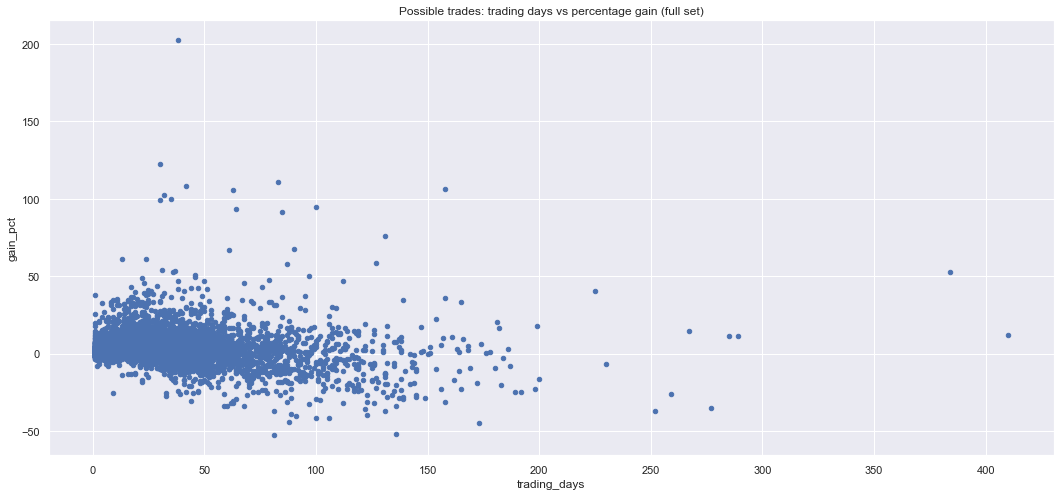

In [16]:
temp_df.plot.scatter(x='trading_days', y='gain_pct', figsize=(18,8))
plt.title('Possible trades: trading days vs percentage gain (full set)')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


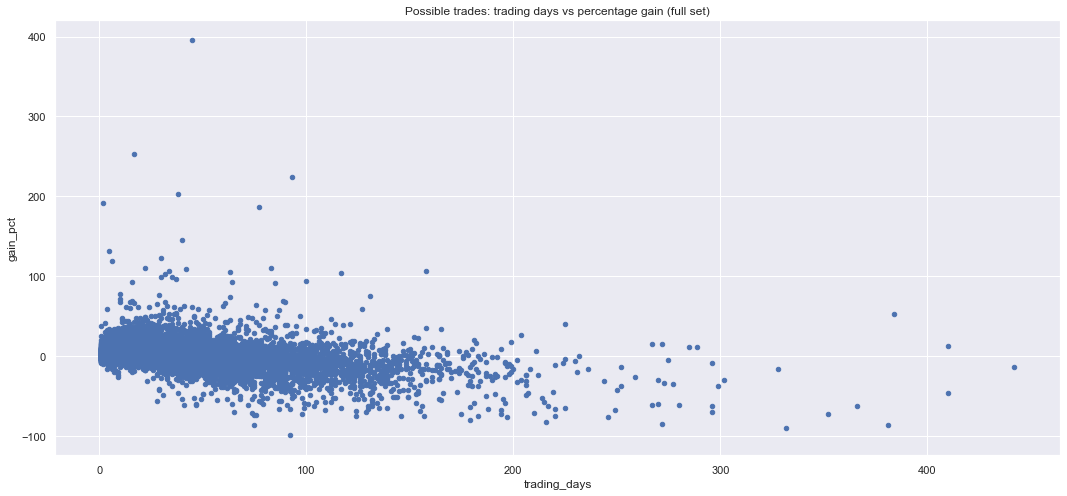

In [17]:
possible_trades_df.plot.scatter(x='trading_days', y='gain_pct', figsize=(18,8))
plt.title('Possible trades: trading days vs percentage gain (full set)')
plt.show()

# Comparing the Gain Ratios

The cell below show the gain ratio without applying heuristic (0.66) and with applying the heuristic (0.80). This is a better ratio, but reduces the number of possible trades by sixty percent. Implementing the heuristic will allow us to assess the net impact.

In [18]:
possible_trades_df['gain'][possible_trades_df.gain > 0].agg(['sum', 'count'])

sum      45384.9995
count    13858.0000
Name: gain, dtype: float64

In [19]:
possible_trades_df['gain'][possible_trades_df.gain < 0].agg(['sum', 'count'])

sum     -21083.3934
count     6786.0000
Name: gain, dtype: float64

In [20]:
possible_trades_df['gain'][possible_trades_df.gain == 0].agg(['sum', 'count'])

sum        0.0
count    272.0
Name: gain, dtype: float64

In [21]:
(13858 / ( 6786 + 272 + 13858))

0.6625549818320903

In [22]:
temp_df['gain'][temp_df.gain > 0].agg(['sum', 'count'])

sum      21767.5137
count     6572.0000
Name: gain, dtype: float64

In [23]:
temp_df['gain'][temp_df.gain < 0].agg(['sum', 'count'])

sum     -5000.8387
count    1604.0000
Name: gain, dtype: float64

In [24]:
temp_df['gain'][temp_df.gain == 0].agg(['sum', 'count'])

sum       0.0
count    72.0
Name: gain, dtype: float64

In [25]:
6572 / (6572 + 1604 + 72)

0.7967992240543162

# Save Ticker Stats DataFrame

Add an indicator whether the backtester should allow the ticker and then save the dataframe as an CSV file.

In [27]:
ticker_stats_df['good'] = 0
for t in good_tickers:
    ticker_stats_df.good.loc[ticker_stats_df.ticker == t] = 1
sum(ticker_stats_df.good)

737

Make sure we have the same set of tickers.

In [28]:
check_tickers_set = set(ticker_stats_df.ticker.loc[ticker_stats_df.good == 1].to_list())
check_tickers_set == set(good_tickers)

True

Save the dataframe for use by backtester().

In [33]:
ticker_stats_df.to_csv(f'{DATAPATH}ticker_stats.csv')

In [34]:
ls ../data

F13_Renaissance_tech.csv  capital_1000.csv          possible_trades_2000.csv
F13_Renaissance_tech.txt  capital_1500.csv          stocks.csv
PnL_0100.csv              capital_2000.csv          stocks_100.csv
PnL_0500.csv              exclude.csv               stocks_1000.csv
PnL_1000.csv              optimal_params.csv        stocks_2000.csv
PnL_1500.csv              possible_trades_0100.csv  stocks_500.csv
PnL_2000.csv              possible_trades_0500.csv  ticker_stats.csv
capital_0100.csv          possible_trades_1000.csv
capital_0500.csv          possible_trades_1500.csv
